In [31]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [32]:
mat = scipy.io.loadmat('data.mat')
task_f1 = mat['F1']
task_f2 = mat['F2']

In [33]:
f1_np = np.array(task_f1)
f2_np = np.array(task_f2)

In [34]:
col_names = ["C1", "C2", "C3", "C4", "C5"]

In [35]:
f1_df = pd.DataFrame(data = f1_np, columns = col_names)
f2_df = pd.DataFrame(data = f2_np, columns = col_names)
f1_train = f1_df.head(100)
f2_train = f2_df.head(100)
f1_test = f1_df.tail(900)
f2_test = f2_df.tail(900)

### 1 Training

In [36]:
f1_desc = f1_train.describe()

In [37]:
f2_desc = f2_train.describe()

In [38]:
f1_mean = {}; f2_mean = {}; f1_var = {}; f2_var = {}
for col_name in col_names:
    f1_mean[col_name] = f1_desc[col_name]["mean"]
    f2_mean[col_name] = f2_desc[col_name]["mean"]
    f1_var[col_name] = f1_desc[col_name]["std"]**2
    f2_var[col_name] = f2_desc[col_name]["std"]**2

### 2.1 Testing

In [39]:
def get_prob_for_class(data_point, class_mean, class_variance):
    # use the normal pmf of a class to predict the prob of the data point
    exp_power = (-1/(2*class_variance)) * (data_point - class_mean)**2
    exp_term = math.exp(exp_power)
    denom_term = 1/(2*math.pi * class_variance)**(1/2)
    return denom_term * exp_term

def get_prediction(data_point, all_class_mean, all_class_variance):
    # gets the data point, the mean and standard deviation for every class/task
    # returns the class and the probability of the winning class
    task_names = ["C1", "C2", "C3", "C4", "C5"];
    highest_prob = 0
    highest_prob_class = ""
    for task_name in task_names:
        prob = get_prob_for_class(data_point, all_class_mean[task_name], all_class_variance[task_name])
        #print("  Prob of belonging to: "+task_name+" is: "+str(round(prob, 2)))
        if prob > highest_prob:
            highest_prob = prob
            highest_prob_class = task_name
            
    result = {'class' : highest_prob_class, 'prob': round(highest_prob, 2)}
    return result

In [40]:
ctr = 0;
correct_pred = 0;
for test_row_index in f1_test.index:
    # run through all the rows
    test_row = f1_test.loc[test_row_index]
    hightest_prob = 0;
    hightest_prob_class = "";
    # run through each column/data point in a row
    for task_name in col_names:
        prediction = get_prediction(test_row[task_name], f1_mean, f1_var)
        if prediction['class'] == task_name:
            correct_pred = correct_pred + 1
        #print(str(test_row_index)+", "+task_name+":"+str(test_row[task_name]) +", Pred: "+prediction['class']+", Prob:"+str(prediction['prob']))
    #ctr = ctr + 1
    #if ctr == 1:
    #    break

accuracy = (correct_pred / 4500)*100
error = 100-accuracy

In [41]:
print("Prediction accuracy for F1 is: "+str(round(accuracy, 2))+", and error is: "+str(round(error, 2)))

Prediction accuracy for F1 is: 53.0, and error is: 47.0


### 3 Standard normal (Z-score)

In [50]:
def aggregate_data_points(measurement_data_frame):
    data_points = list()
    classes = list()
    count = f1_test.shape[0]
    for i in range(5):
        data_points.append(measurement_data_frame.iloc[:, i])
        classes.append([i]*count)
    result = {'data_points': list(data_points), 'classes' : classes}
    return result

def plot_measurements(measure1, measure2, title):
    task_names = ["C1", "C2", "C3", "C4", "C5"]
    color = ["coral", "lightblue", "lightgreen", "pink", "purple"]
    ctr = 0;
    for task_name in task_names:
        plt.scatter(measure1[task_name], measure2[task_name], c=color[ctr])
        ctr = ctr + 1
    plt.title(title)
    plt.xlabel('F1')
    plt.ylabel('F2')
    plt.show()
    
def get_stats(meas_df_train):
    df_desc = meas_df_train.describe()
    mean = {}; var = {};
    col_names = ["C1", "C2", "C3", "C4", "C5"]
    for col_name in col_names:
        mean[col_name] = df_desc[col_name]["mean"]
        var[col_name] = df_desc[col_name]["std"]**2
    return {'mean' : mean, 'var': var}

def normalize_data(measurement_dataframe):
    mat = scipy.io.loadmat('data.mat')
    f1=mat['F1']
    f2=mat['F2']
    task_names = ["C1", "C2", "C3", "C4", "C5"]
    stats = get_stats(measurement_dataframe)
    mean = stats['mean']
    var = stats['var']
    normalized_data = {}
    daf1 = pd.DataFrame({'C1':f1[:,0],'C2':f1[:,1],'C3':f1[:,2],'C4':f1[:,3],'C5':f1[:,4]})
    daf1
    
    for i in range(daf1.shape[0]):
        for j in range(daf1.shape[1]):
            daf1.iloc[i,j]=(daf1.iloc[i,j]-np.mean(daf1.iloc[i,:]))/np.std(daf1.iloc[i,:])
    
    return daf1

def predict_complete(f1_norm_test, stats):
    ctr = 0;
    correct_pred = 0;
    for test_row_index in f1_norm_test.index:
        # run through all the rows
        test_row = f1_norm_test.loc[test_row_index]
        hightest_prob = 0;
        hightest_prob_class = "";
        # run through each column/data point in a row
        for task_name in col_names:
            prediction = get_prediction(test_row[task_name], stats['mean'], stats['var'])
            if prediction['class'] == task_name:
                correct_pred = correct_pred + 1
            
    accuracy = (correct_pred / 4500)*100
    return accuracy;

In [51]:
normalize_data(f1_df)

,C1,C2,C3,C4,C5
0,-0.482923,0.229925,-0.256143,1.391828,1.981029
1,-0.478534,0.637172,-0.563755,1.410247,1.968096
2,-0.631612,0.023609,-0.335737,1.255910,1.982677
3,-0.401305,0.411884,-0.701382,1.409829,1.958301
4,-0.358164,-0.008284,-0.269970,1.431489,1.981010
...,...,...,...,...,...
995,-0.180072,0.358104,-0.376581,1.407752,1.979866
996,-0.288173,0.007092,-0.345132,1.430839,1.970032
997,-0.743168,0.254397,-0.370814,1.342941,1.974188
998,-0.675000,0.179821,0.154263,1.343453,1.984415


The plot shown below is for non-normalized values

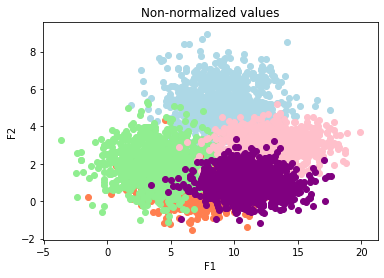

In [52]:
plot_measurements(f1_df, f2_df,'Non-normalized values')

In [53]:
f1_normalized = normalize_data(f1_df)

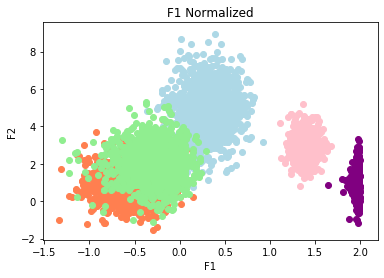

In [54]:
plot_measurements(f1_normalized, f2_df, 'F1 Normalized')

In [55]:
f1_norm_train = f1_normalized.head(100)
f1_norm_test = f1_normalized.tail(900)
f1_train = f1_df.head(100)
f1_test = f1_df.tail(900)

In [56]:
predict_complete(f1_norm_test, stats)

20.0

In [57]:
stats = get_stats(f1_train)

In [58]:
stats = {'mean' : f1_mean, 'var': f1_var}
predict_complete(f1_test, stats)

53.0

In [59]:
partial = f1_df.iloc[0:5,:]
partial

,C1,C2,C3,C4,C5
0,7.905430,9.035490,4.534891,14.166835,11.883470
1,6.603707,10.298966,1.998801,12.687553,10.392322
2,6.108960,7.101807,3.629037,12.606273,12.205932
3,5.295339,7.438817,0.769919,11.009843,9.003759
4,8.086083,7.633613,4.485315,14.777762,11.850740


In [60]:
st = get_stats(partial)

In [61]:
st

{'mean': {'C1': 6.7999040519267195,
  'C2': 8.301738365509555,
  'C3': 3.0835922661543047,
  'C4': 13.049653176842122,
  'C5': 11.067244893481341},
 'var': {'C1': 1.4140148259463967,
  'C2': 1.7895422599396607,
  'C3': 2.7246155367955924,
  'C4': 2.180745210577822,
  'C5': 1.8225479683101031}}

In [62]:
part_norm = normalize_data(partial)

In [63]:
part_norm

,C1,C2,C3,C4,C5
0,-0.482923,0.229925,-0.256143,1.391828,1.981029
1,-0.478534,0.637172,-0.563755,1.410247,1.968096
2,-0.631612,0.023609,-0.335737,1.255910,1.982677
3,-0.401305,0.411884,-0.701382,1.409829,1.958301
4,-0.358164,-0.008284,-0.269970,1.431489,1.981010
...,...,...,...,...,...
995,-0.180072,0.358104,-0.376581,1.407752,1.979866
996,-0.288173,0.007092,-0.345132,1.430839,1.970032
997,-0.743168,0.254397,-0.370814,1.342941,1.974188
998,-0.675000,0.179821,0.154263,1.343453,1.984415


In [64]:
st_norm = get_stats(part_norm)

In [65]:
st_norm

{'mean': {'C1': -0.5594614600382845,
  'C2': 0.32960017189082946,
  'C3': -0.29881579004770636,
  'C4': 1.383284764026894,
  'C5': 1.9708252417446195},
 'var': {'C1': 0.05578420720580066,
  'C2': 0.03929350027909665,
  'C3': 0.058972970621180676,
  'C4': 0.006042965622695494,
  'C5': 0.0004936757290966074}}

# Case 3: X= F2

In [126]:
ctr1 = 0;
correct_pred1 = 0;
for test_row_index1 in f2_test.index:
    # run through all the rows
    test_row1 = f2_test.loc[test_row_index1]
    hightest_prob1 = 0;
    hightest_prob_class1 = "";
    # run through each column/data point in a row
    for task_name in col_names:
        prediction = get_prediction(test_row[task_name], f2_mean, f2_var)
        if prediction['class'] == task_name:
            correct_pred1 = correct_pred1 + 1
    

accuracyCase3 = (correct_pred1 / 4500)*100
errorCase3 = 100-accuracyCase3

In [127]:
print("Prediction accuracy for F2 is: "+str(round(accuracyCase3, 2))+", and error is: "+str(round(errorCase3, 2)))

Prediction accuracy for F2 is: 80.0, and error is: 20.0


# Case 4 : X=[Z1,F2]

In [130]:
# methods to calculate the element wise probability and return the max using argmax
def maxProbaility(l1,l2):
    combinedList = [a*b for a,b in zip(l1,l2)]
    return np.argmax(combinedList)+1

def find_Class(data, m, sd):
    pClass = []
    for i in range(5):
        exp = math.exp(-(math.pow(data-m[i],2)/(2*math.pow(sd[i],2))))
        value = (1/(math.sqrt(2*math.pi)*sd[i]))*exp
        pClass.append(value)
    return pClass 

def mProbabValue(df_1,df_2,df_1_m,df_1_sd,df_2_m,df_2_sd,initial=100,final=1000):
    dataframePred = pd.DataFrame(columns=['class1','class2', 'class3','class4', 'class5'])  
    for i in range(initial,final):
        lPList = []
        for j in range(0,5):    
            dValue1 = df_1.iloc[i][j]
            dValue2 = df_2.iloc[i][j]
            lP1 = find_Class(dValue1,df_1_m,df_1_sd)
            lP2 = find_Class(dValue2,df_2_m,df_2_sd)
            mL1 = maxProbaility(lP1,lP2)
            lPList.append(mL1)
        dataframePred.loc[i] = lPList
    return dataframePred

# method to calculate the accuracy rate
def find_accuracy(pvalue):
    ctr = []
    for i in range(5):
        c = pvalue[pvalue.iloc[:,i] == i+1].iloc[:,i].count()
        ctr.append(c)    
    Accuracy_Rate = (np.sum(ctr)/pvalue.size)*100
    return Accuracy_Rate

# X=[Z1 F2]
matData = scipy.io.loadmat('data.mat')
f1Data=matData['F1']
f2Data=matData['F2']

pd_f1 = pd.DataFrame({'C1':f1Data[:,0],'C2':f1Data[:,1],'C3':f1Data[:,2],'C4':f1Data[:,3],'C5':f1Data[:,4]})
for i in range(pd_f1.shape[0]):
    for j in range(pd_f1.shape[1]):
        pd_f1.iloc[i,j]=(pd_f1.iloc[i,j]-np.mean(pd_f1.iloc[i,:]))/np.std(pd_f1.iloc[i,:])

pd_f2=pd.DataFrame({'C1':f2Data[:,0],'C2':f2Data[:,1],'C3':f2Data[:,2],'C4':f2Data[:,3],'C5':f2Data[:,4]})
mZ1 = pd_f1[0:100].mean(axis = 0)
sdZ1 = pd_f1[0:100].std(axis = 0)
mF2 = pd_f2[0:100].mean(axis = 0)
sdF2 = pd_f2[0:100].std(axis = 0)
valueDF = mProbabValue(pd_f1,pd_f2,mZ1,sdZ1,mF2,sdF2)
 
accuracyCase4 = find_accuracy(valueDF)
errorCase4 = 100 - accuracyCase4

In [131]:
print("Prediction accuracy for X=[Z1,F2] is: "+str(round(accuracyCase4, 2)) +", and error is: "+ str(round(errorCase4, 2)))


Prediction accuracy for X=[Z1,F2] is: 89.76, and error is: 10.24
